In [1]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Convert to grayscale if needed (optional)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_data/benign_filtered"
malignant_dir = "/content/drive/MyDrive/Kaggle_data/malignant_filtered"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

# Combine the images
images = np.concatenate((benign_images, malignant_images), axis=0)

# Normalize images (0-1)
images = images.astype(np.float32) / 255.0  # Ensure correct dtype for normalization

# Shuffle images
np.random.shuffle(images)

print(f"Total images loaded: {images.shape[0]}")


Loaded 1800 images from /content/drive/MyDrive/Kaggle_data/benign_filtered
Loaded 1507 images from /content/drive/MyDrive/Kaggle_data/malignant_filtered
Total images loaded: 3307


In [3]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [4]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold - 30, 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold + 30, 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2645, 128, 128, 3), Training masks shape: (2645, 128, 128, 1)
Validation images shape: (662, 128, 128, 3), Validation masks shape: (662, 128, 128, 1)


In [5]:
import numpy as np

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

def r2u_net(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Convolution Block 1
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    # Convolution Block 2
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Convolution Block 3
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Convolution Block 4
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bn = tf.keras.layers.BatchNormalization()(bn)
    bn = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)
    bn = tf.keras.layers.BatchNormalization()(bn)

    # Upsampling and Concatenation
    u1 = tf.keras.layers.UpSampling2D((2, 2))(bn)
    u1 = tf.keras.layers.concatenate([u1, c4])
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = Dropout(0.5)(c5)  # Dropout layer

    u2 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    u2 = tf.keras.layers.concatenate([u2, c3])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = Dropout(0.5)(c6)  # Dropout layer

    u3 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    u3 = tf.keras.layers.concatenate([u3, c2])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = Dropout(0.5)(c7)  # Dropout layer

    u4 = tf.keras.layers.UpSampling2D((2, 2))(c7)
    u4 = tf.keras.layers.concatenate([u4, c1])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = Dropout(0.5)(c8)  # Dropout layer

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
r2u_net_model = r2u_net((128, 128, 3))


In [7]:
import numpy as np
from scipy.special import gamma

class ANBOOptimizer:
    def __init__(self, model, lb, ub, population_size=30, max_iter=100):
        self.model = model
        self.lb = lb
        self.ub = ub
        self.population_size = population_size
        self.max_iter = max_iter

        # Keep track of the layer weight shapes
        self.weight_shapes = [w.shape for w in model.get_weights()]

        # Compute total number of weights (flattened size)
        self.total_weights = sum(np.prod(shape) for shape in self.weight_shapes)

        # Initialize the population
        self.population = self.initialize_population()

        # Initialize the visit table (population_size x population_size)
        self.visit_table = np.zeros((self.population_size, self.population_size))

    def initialize_population(self):
        # Initialize a population of flattened weight vectors
        return [self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb) for _ in range(self.population_size)]

    def flatten_weights(self, weights):
        # Flatten the model weights into a 1D array
        return np.concatenate([w.flatten() for w in weights])

    def reshape_weights(self, flattened_weights):
        # Reshape the flattened weight vector back to the model's original weight shapes
        reshaped_weights = []
        start = 0
        for shape in self.weight_shapes:
            size = np.prod(shape)
            reshaped_weights.append(flattened_weights[start:start + size].reshape(shape))
            start += size
        return reshaped_weights

    def fitness(self, flattened_weights, X, y_true, batch_size=32):
        # Reshape the flattened weights to the original layer weight shapes
        reshaped_weights = self.reshape_weights(flattened_weights)
        self.model.set_weights(reshaped_weights)

        # Compute the fitness (mean squared error) using batch processing
        num_samples = X.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        total_loss = 0
        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y_true[start:end]
            y_pred = self.model.predict(X_batch)
            total_loss += np.sum((y_pred - y_batch) ** 2)

        mean_loss = total_loss / num_samples
        return mean_loss

    def guided_foraging(self, Su, Su_tar):
        lambda_factor = np.random.normal(0, 1)
        Vu_next = Su_tar + lambda_factor * (Su - Su_tar)
        return np.clip(Vu_next, self.lb, self.ub)

    def levy_flight(self, beta=1.5):
        u = np.random.normal(0, 1)
        v = np.random.normal(0, 1)
        gamma_numerator = gamma(1 + beta) * np.sin(np.pi * beta / 2)
        gamma_denominator = gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
        levy_constant = (gamma_numerator / gamma_denominator) ** (1 / beta)
        levy_step = u / (np.abs(v) ** (1 / beta)) * levy_constant
        return levy_step

    def territorial_foraging(self, Su):
        # Exploring nearby regions
        lambda_star = np.random.normal(0, 1)
        territorial_step = lambda_star * Su
        return np.clip(Su + territorial_step, self.lb, self.ub)

    def migration_foraging(self):
        # Return a new random location
        return self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb)

    def update_position(self, Su, Sj, humidity):
        levy_step = self.levy_flight()
        return Su + humidity * (Sj - Su) + levy_step

    def update_visit_table(self, worst_idx):
        # Update visit table for v-th source, v ≠ wor
        for v in range(self.population_size):
            if v != worst_idx:
                self.visit_table[worst_idx, v] += 1

    def optimize(self, X_train, y_train):
        best_solution = None
        best_fitness = float('inf')

        for iteration in range(self.max_iter):
            for i, Su in enumerate(self.population):
                fitness_val = self.fitness(Su, X_train, y_train)

                if fitness_val < best_fitness:
                    best_fitness = fitness_val
                    best_solution = Su

                # Guided Foraging
                Su_tar = self.population[np.random.randint(self.population_size)]
                Su_next = self.guided_foraging(Su, Su_tar)

                # Territorial Foraging (Local exploration)
                if np.random.rand() > 0.5:
                    Su_next = self.territorial_foraging(Su)

                # Migration Foraging (Random jump if stuck)
                if np.random.rand() > 0.7 or iteration % (2 * self.population_size) == 0:
                    worst_idx = i  # Assuming i is the worst index for now
                    Su_next = self.migration_foraging()
                    self.update_visit_table(worst_idx)  # Update visit table after migration

                # Update population with new position
                self.population[i] = Su_next

        # Return the best solution and best fitness
        return self.reshape_weights(best_solution), best_fitness


In [8]:

# Initialize the R2U-Net model
from sklearn.model_selection import train_test_split



lb = -0.0001  # Single lower bound
ub = 0.0001   # Single upper bound

# Initialize the optimizer
optimizer = ANBOOptimizer(r2u_net_model, lb, ub, population_size=4, max_iter=1)

# Run the optimization process
best_weights, best_fitness = optimizer.optimize(X_train, y_train)

# Set the model's weights to the best solution
r2u_net_model.set_weights(best_weights)





1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [9]:

r2u_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
# Fit the model with early stopping
history = r2u_net_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]  # include the early stopping callback
)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6650 - loss: 0.6777 - val_accuracy: 0.6735 - val_loss: 0.5911
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 380ms/step - accuracy: 0.6799 - loss: 0.5791 - val_accuracy: 0.6735 - val_loss: 0.5793
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 379ms/step - accuracy: 0.6667 - loss: 0.5872 - val_accuracy: 0.6735 - val_loss: 0.6112
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.6690 - loss: 0.5773 - val_accuracy: 0.6765 - val_loss: 3.2461
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.7763 - loss: 0.3519 - val_accuracy: 0.7344 - val_loss: 0.4452
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - accuracy: 0.8253 - loss: 0.2632 - val_accuracy: 0.7846 - val_loss: 0.3798
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - accuracy: 0.8322 - loss: 0.2423 - val_accuracy: 0.8201 - val_loss: 0.2738
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.8321 - loss: 0.2406 - val_accura

In [10]:
# Predict on validation set
y_pred_val = r2u_net_model.predict(X_val)

# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")



21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
Jaccard Coefficient (IoU): 0.872097121518977
Dice Coefficient : 0.9316793573309672


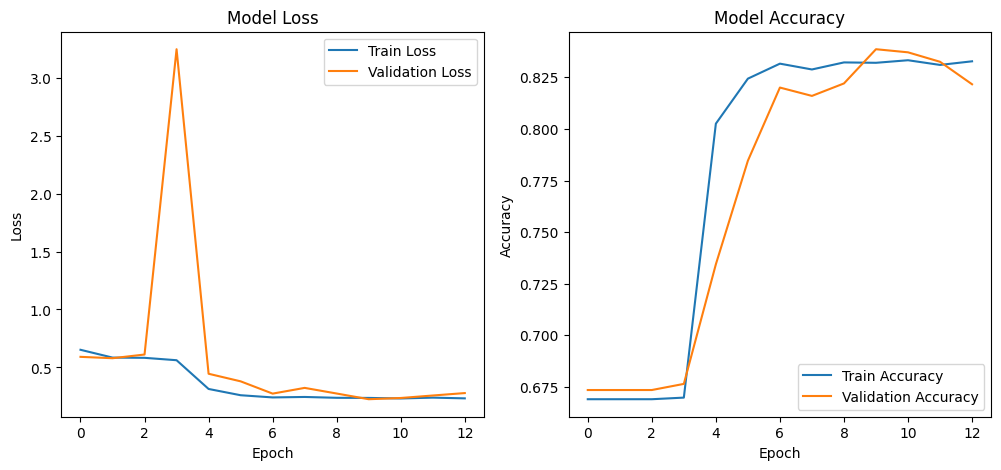

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


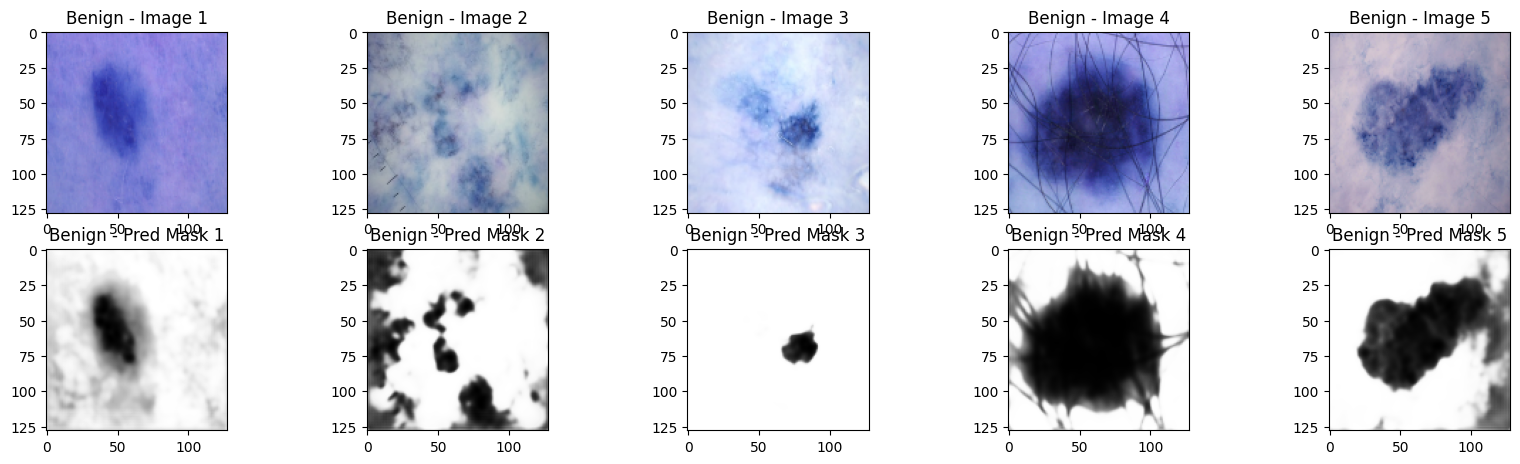

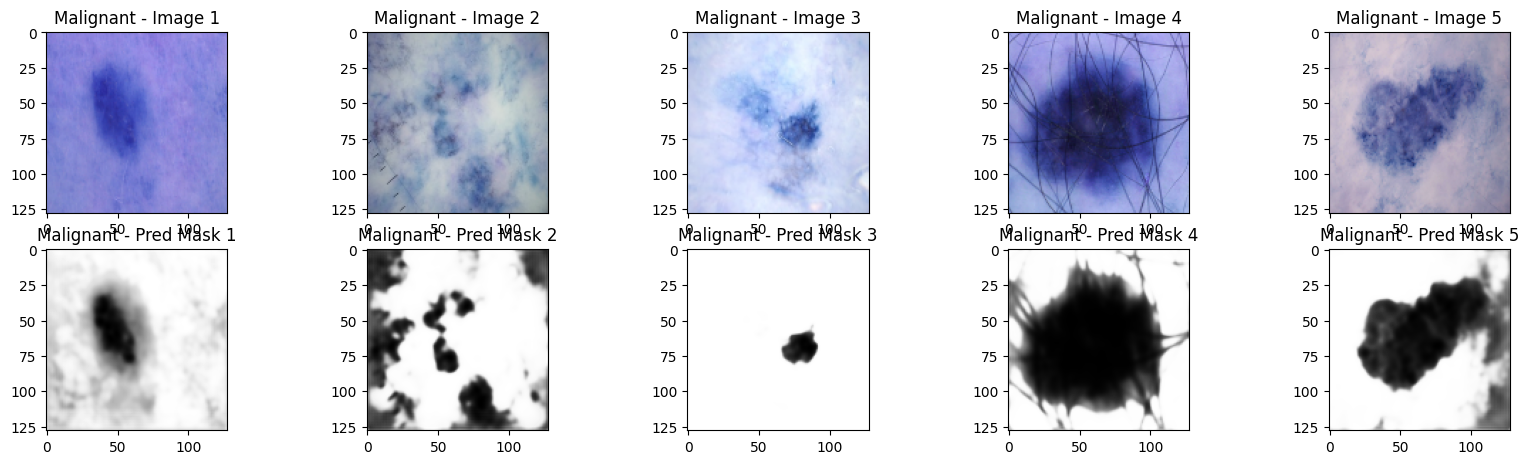

In [12]:
# Make predictions on validation images
predictions = r2u_net_model.predict(X_val)

# Display 5 images from benign and malignant, with their ground truth and predicted masks
def display_images(images, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])


        plt.subplot(3, 5, i + 6)
        plt.title(f"{title} - Pred Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.show()

# Select benign and malignant images for display (first 5 of each from the validation set)
benign_idx = np.arange(len(benign_images))[:5]
malignant_idx = np.arange(len(malignant_images))[:5]

# Display 5 benign images with true and predicted masks
display_images(X_val[benign_idx], predictions[benign_idx], title="Benign")

# Display 5 malignant images with true and predicted masks
display_images(X_val[malignant_idx], predictions[malignant_idx], title="Malignant")

In [13]:
r2u_net_model.save('/content/drive/MyDrive/r2u_net_model_ANBO.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!
